In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
df=pd.read_csv("BTC-USD.csv", skiprows=1)
df.columns=["Time", "Low", "High", "Open","Close","Volume"]
df.head()

,Time,Low,High,Open,Close,Volume
0,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
1,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
2,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000
3,1528968960,6477.959961,6480.000000,6477.959961,6480.000000,1.490900
4,1528969020,6477.220215,6480.000000,6479.990234,6477.220215,2.731950


In [3]:
len(df)

97722

In [4]:
df=df[:3000]

In [5]:
len(df)

3000

In [6]:
last_5pct=int(0.05*len(df))

In [7]:
last_5pct

150

In [8]:
split_time=2500

In [9]:
df=df[["Time","Close"]]
df.head()

,Time,Close
0,1528968780,6479.410156
1,1528968840,6479.410156
2,1528968900,6479.979980
3,1528968960,6480.000000
4,1528969020,6477.220215


In [10]:
df.head()

,Time,Close
0,1528968780,6479.410156
1,1528968840,6479.410156
2,1528968900,6479.979980
3,1528968960,6480.000000
4,1528969020,6477.220215


In [11]:
min(df["Close"])

6310.009765999999

In [12]:
max(df["Close"])

6693.660156

In [13]:
df["Close_norm"]=(df["Close"]-min(df["Close"]))/(max(df["Close"])-min(df["Close"]))

In [14]:
df.head()

,Time,Close,Close_norm
0,1528968780,6479.410156,0.441549
1,1528968840,6479.410156,0.441549
2,1528968900,6479.979980,0.443034
3,1528968960,6480.000000,0.443086
4,1528969020,6477.220215,0.435841


In [15]:
df["Close2"]=(df["Close_norm"]*(max(df["Close"])-min(df["Close"])))+min(df["Close"])

In [16]:
df=df[["Time","Close","Close_norm"]]
df.head()

,Time,Close,Close_norm
0,1528968780,6479.410156,0.441549
1,1528968840,6479.410156,0.441549
2,1528968900,6479.979980,0.443034
3,1528968960,6480.000000,0.443086
4,1528969020,6477.220215,0.435841


In [17]:
time=df.iloc[:,0].values

In [18]:
time_train=time[:split_time]
time_valid=time[split_time:]

In [19]:
series=df.iloc[:,2].values

In [20]:
x_train=series[:split_time]
x_valid=series[split_time:]

In [21]:
plot=df.iloc[:,1].values

In [22]:
plot_train=plot[:split_time]
plot_valid=plot[split_time:]

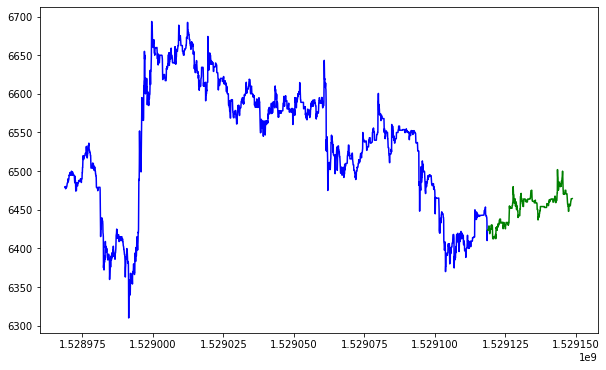

In [23]:
plt.figure(figsize=(10,6))
plt.plot(time_train, plot_train, color="b")
plt.plot(time_valid, plot_valid, color="green")
plt.show()

In [24]:
window_size=30
batch_size=32
shuffle_buffer_size=500

In [25]:
def windowed_dataset(series, batch_size, window_size, buffer_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.shuffle(buffer_size).map(lambda window: (window[:-1], window[-1:]))
    dataset=dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [26]:
train_data=windowed_dataset(x_train, batch_size, window_size, shuffle_buffer_size )

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [28]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                          padding="causal",activation="relu", input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [29]:
optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
loss=tf.keras.losses.Huber()

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/10))

model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])

In [30]:
history=model.fit(train_data, epochs=50, verbose=1, callbacks=[lr_scheduler])

Epoch 1/50
78/78 [==============================] - 5s 60ms/step - loss: 0.2184 - mae: 0.6224
Epoch 2/50
78/78 [==============================] - 1s 9ms/step - loss: 0.2178 - mae: 0.6207
Epoch 3/50
78/78 [==============================] - 1s 8ms/step - loss: 0.2172 - mae: 0.6184
Epoch 4/50
78/78 [==============================] - 1s 8ms/step - loss: 0.2152 - mae: 0.6156
Epoch 5/50
78/78 [==============================] - 1s 8ms/step - loss: 0.2123 - mae: 0.6121
Epoch 6/50
78/78 [==============================] - 1s 8ms/step - loss: 0.2093 - mae: 0.6077
Epoch 7/50
78/78 [==============================] - 1s 9ms/step - loss: 0.2055 - mae: 0.6021
Epoch 8/50
78/78 [==============================] - 1s 8ms/step - loss: 0.2021 - mae: 0.5951
Epoch 9/50
78/78 [==============================] - 1s 9ms/step - loss: 0.1965 - mae: 0.5868
Epoch 10/50
78/78 [==============================] - 1s 9ms/step - loss: 0.1906 - mae: 0.5769
Epoch 11/50
78/78 [==============================] - 1s 9ms/step - l

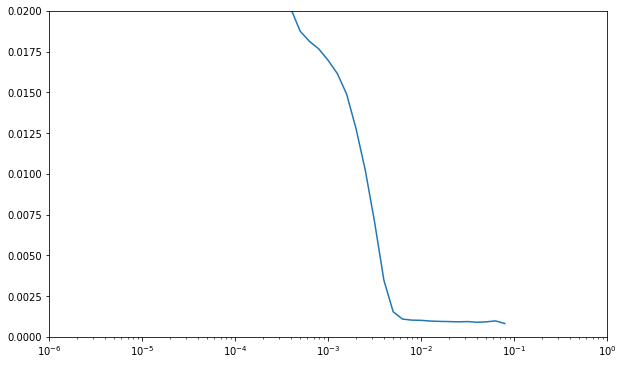

In [31]:
plt.figure(figsize=(10,6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6,1,0,0.02])
plt.show()

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [33]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                          padding="causal",activation="relu", input_shape=[None,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [34]:
optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-5)
loss=tf.keras.losses.Huber()

model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])

In [35]:
history=model.fit(train_data, epochs=500, verbose=1)

Epoch 1/500
78/78 [==============================] - 3s 39ms/step - loss: 0.0332 - mae: 0.1882
Epoch 2/500
78/78 [==============================] - 1s 8ms/step - loss: 0.0149 - mae: 0.1316
Epoch 3/500
78/78 [==============================] - 1s 8ms/step - loss: 0.0068 - mae: 0.0835
Epoch 4/500
78/78 [==============================] - 1s 7ms/step - loss: 0.0014 - mae: 0.0367
Epoch 5/500
78/78 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0306
Epoch 6/500
78/78 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0303
Epoch 7/500
78/78 [==============================] - 1s 8ms/step - loss: 9.9689e-04 - mae: 0.0299
Epoch 8/500
78/78 [==============================] - 1s 8ms/step - loss: 9.6922e-04 - mae: 0.0290
Epoch 9/500
78/78 [==============================] - 1s 7ms/step - loss: 9.6692e-04 - mae: 0.0293
Epoch 10/500
78/78 [==============================] - 1s 8ms/step - loss: 9.7705e-04 - mae: 0.0291
Epoch 11/500
78/78 [======================

78/78 [==============================] - 1s 8ms/step - loss: 5.8259e-04 - mae: 0.0218
Epoch 85/500
78/78 [==============================] - 1s 7ms/step - loss: 5.7452e-04 - mae: 0.0214
Epoch 86/500
78/78 [==============================] - 1s 8ms/step - loss: 5.8694e-04 - mae: 0.0225
Epoch 87/500
78/78 [==============================] - 1s 7ms/step - loss: 5.6942e-04 - mae: 0.0216
Epoch 88/500
78/78 [==============================] - 1s 8ms/step - loss: 5.6122e-04 - mae: 0.0211
Epoch 89/500
78/78 [==============================] - 1s 8ms/step - loss: 5.8496e-04 - mae: 0.0215
Epoch 90/500
78/78 [==============================] - 1s 8ms/step - loss: 5.6243e-04 - mae: 0.0213
Epoch 91/500
78/78 [==============================] - 1s 8ms/step - loss: 5.4831e-04 - mae: 0.0210
Epoch 92/500
78/78 [==============================] - 1s 8ms/step - loss: 5.4802e-04 - mae: 0.0209
Epoch 93/500
78/78 [==============================] - 1s 8ms/step - loss: 5.4555e-04 - mae: 0.0212
Epoch 94/500
78/78 [===

78/78 [==============================] - 1s 8ms/step - loss: 4.5414e-04 - mae: 0.0197
Epoch 167/500
78/78 [==============================] - 1s 8ms/step - loss: 4.4743e-04 - mae: 0.0193
Epoch 168/500
78/78 [==============================] - 1s 7ms/step - loss: 4.3800e-04 - mae: 0.0191
Epoch 169/500
78/78 [==============================] - 1s 8ms/step - loss: 4.3873e-04 - mae: 0.0193
Epoch 170/500
78/78 [==============================] - 1s 8ms/step - loss: 4.4262e-04 - mae: 0.0192
Epoch 171/500
78/78 [==============================] - 1s 8ms/step - loss: 4.4703e-04 - mae: 0.0194
Epoch 172/500
78/78 [==============================] - 1s 8ms/step - loss: 4.5643e-04 - mae: 0.0192
Epoch 173/500
78/78 [==============================] - 1s 8ms/step - loss: 4.4063e-04 - mae: 0.0193
Epoch 174/500
78/78 [==============================] - 1s 8ms/step - loss: 4.3483e-04 - mae: 0.0190
Epoch 175/500
78/78 [==============================] - 1s 8ms/step - loss: 4.3862e-04 - mae: 0.0193
Epoch 176/500


78/78 [==============================] - 1s 8ms/step - loss: 3.8771e-04 - mae: 0.0179
Epoch 249/500
78/78 [==============================] - 1s 8ms/step - loss: 3.9333e-04 - mae: 0.0183
Epoch 250/500
78/78 [==============================] - 1s 8ms/step - loss: 3.9860e-04 - mae: 0.0181
Epoch 251/500
78/78 [==============================] - 1s 8ms/step - loss: 3.9408e-04 - mae: 0.0183
Epoch 252/500
78/78 [==============================] - 1s 8ms/step - loss: 3.8728e-04 - mae: 0.0179
Epoch 253/500
78/78 [==============================] - 1s 7ms/step - loss: 3.9147e-04 - mae: 0.0181
Epoch 254/500
78/78 [==============================] - 1s 8ms/step - loss: 3.8640e-04 - mae: 0.0178
Epoch 255/500
78/78 [==============================] - 1s 7ms/step - loss: 3.8504e-04 - mae: 0.0178
Epoch 256/500
78/78 [==============================] - 1s 8ms/step - loss: 3.9109e-04 - mae: 0.0179
Epoch 257/500
78/78 [==============================] - 1s 8ms/step - loss: 3.9863e-04 - mae: 0.0184
Epoch 258/500


78/78 [==============================] - 1s 8ms/step - loss: 3.7180e-04 - mae: 0.0175
Epoch 330/500
78/78 [==============================] - 1s 8ms/step - loss: 3.5769e-04 - mae: 0.0169
Epoch 331/500
78/78 [==============================] - 1s 8ms/step - loss: 3.6294e-04 - mae: 0.0174
Epoch 332/500
78/78 [==============================] - 1s 8ms/step - loss: 3.4957e-04 - mae: 0.0168
Epoch 333/500
78/78 [==============================] - 1s 8ms/step - loss: 3.5350e-04 - mae: 0.0170
Epoch 334/500
78/78 [==============================] - 1s 8ms/step - loss: 3.6161e-04 - mae: 0.0171
Epoch 335/500
78/78 [==============================] - 1s 8ms/step - loss: 3.5835e-04 - mae: 0.0171
Epoch 336/500
78/78 [==============================] - 1s 8ms/step - loss: 3.4975e-04 - mae: 0.0169
Epoch 337/500
78/78 [==============================] - 1s 8ms/step - loss: 3.5250e-04 - mae: 0.0172
Epoch 338/500
78/78 [==============================] - 1s 8ms/step - loss: 3.4819e-04 - mae: 0.0167
Epoch 339/500


78/78 [==============================] - 1s 8ms/step - loss: 3.3260e-04 - mae: 0.0161
Epoch 411/500
78/78 [==============================] - 1s 8ms/step - loss: 3.3213e-04 - mae: 0.0164
Epoch 412/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2469e-04 - mae: 0.0161
Epoch 413/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2354e-04 - mae: 0.0161
Epoch 414/500
78/78 [==============================] - 1s 7ms/step - loss: 3.2989e-04 - mae: 0.0166
Epoch 415/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2820e-04 - mae: 0.0162
Epoch 416/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2315e-04 - mae: 0.0160
Epoch 417/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2850e-04 - mae: 0.0162
Epoch 418/500
78/78 [==============================] - 1s 8ms/step - loss: 3.3105e-04 - mae: 0.0164
Epoch 419/500
78/78 [==============================] - 1s 8ms/step - loss: 3.2186e-04 - mae: 0.0160
Epoch 420/500


78/78 [==============================] - 1s 8ms/step - loss: 3.0110e-04 - mae: 0.0154
Epoch 493/500
78/78 [==============================] - 1s 8ms/step - loss: 3.1139e-04 - mae: 0.0154
Epoch 494/500
78/78 [==============================] - 1s 8ms/step - loss: 3.0068e-04 - mae: 0.0154
Epoch 495/500
78/78 [==============================] - 1s 8ms/step - loss: 2.9872e-04 - mae: 0.0153
Epoch 496/500
78/78 [==============================] - 1s 8ms/step - loss: 3.0509e-04 - mae: 0.0156
Epoch 497/500
78/78 [==============================] - 1s 8ms/step - loss: 3.0464e-04 - mae: 0.0156
Epoch 498/500
78/78 [==============================] - 1s 8ms/step - loss: 3.0194e-04 - mae: 0.0155
Epoch 499/500
78/78 [==============================] - 1s 8ms/step - loss: 2.9828e-04 - mae: 0.0152
Epoch 500/500
78/78 [==============================] - 1s 8ms/step - loss: 2.9985e-04 - mae: 0.0153


In [36]:
forecast=[]

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast=forecast[split_time-window_size:]
forecast=np.array(forecast)[:,0,0]

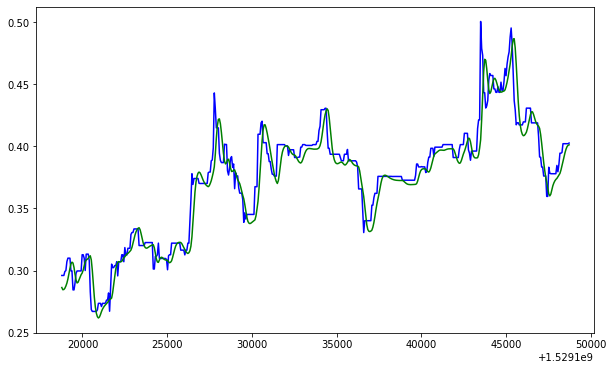

In [37]:
plt.figure(figsize=(10,6))
plt.plot(time_valid, x_valid, color="b")
plt.plot(time_valid, forecast, color="g")
plt.show()

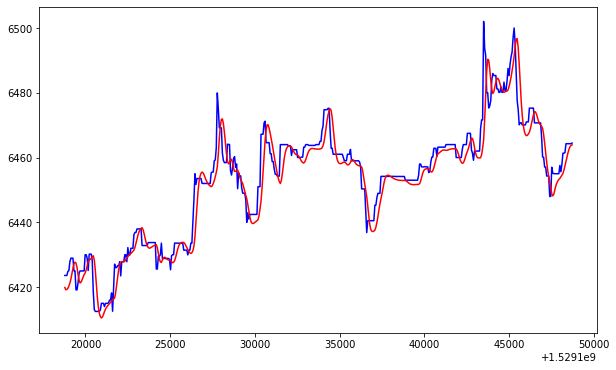

In [39]:
plot_forecast=(forecast*(max(df["Close"])-min(df["Close"])))+min(df["Close"])
plt.figure(figsize=(10,6))
plt.plot(time_valid, plot_valid, color="b")
plt.plot(time_valid, plot_forecast, color="r")
plt.show()

In [41]:
tf.keras.metrics.mean_absolute_error(plot_valid, plot_forecast).numpy()

3.5532804